# Exploratory Data Analysis Part 2:
## Feature Extraction

From the previous notebook, a few features were ommited from analysis due to their complexity.  They will be evaluated here.

Per the previous notebook:

The remaining features which have not yet been investigated are provided as follows, along with a brief plan to evaluate each of those features:
* amenities
    * These need to be separated out into the individual amenties, counted up, and one hot encoded
* description
    * This will require some manual examination and NLP techniques to attmept to find useful features
* host_about
    * This will require some manual examination and NLP techniques to attmept to find useful features
* name
    * This will require some manual examination and NLP techniques to attmept to find useful features
* neighborhood_overview
    * This will require some manual examination and NLP techniques to attmept to find useful features
* host_location
    * This will need to be combined with host_neighbourhood and encoded accordingly
* host_neighbourhood
    * This will need to be combined with host_location and encoded accordingly
* license
    * This will require come NLP techniques to extract similar values

In [105]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

# 1 - Read Data and Examine Dataframe

In [2]:
# keep the same dataframe name as in the previous notebook
lstn = pd.read_csv('../data/listings_train_2.csv')

In [3]:
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3477 non-null   int64  
 1   name                                          3477 non-null   object 
 2   description                                   3464 non-null   object 
 3   neighborhood_overview                         2245 non-null   object 
 4   host_id                                       3477 non-null   int64  
 5   host_since                                    3477 non-null   float64
 6   host_location                                 2683 non-null   object 
 7   host_about                                    2463 non-null   object 
 8   host_response_time                            3477 non-null   object 
 9   host_response_rate                            3477 non-null   f

# 2 - Required Functions from Previous Notebook

In [106]:
'''
The col_logger function will need to be brough in from the other notebooks

This has been modified to include a 0 imputation value n such that transforamtion
occurs on log(n) and not log(0) which is undefined.
'''

def col_logger(data_column, zero_imp = 1):
    # Since log(0) is undefined, 0's must be treated as log(1)
    return data_column.apply(lambda x: np.log(zero_imp) if x==0 else np.log(x))

In [5]:
# Create a histogram plotting function:
def hist_plotter(data, title = None, x_lbl = None, y_lbl = 'Count',  size = (6,4), bins = None, log = False):
    plt.figure(figsize = size)
    plt.hist(data, bins = bins, log = log)
    if title == None:
        plt.title(f'{data.name}')
    else:
        plt.title(title)
    if x_lbl == None:
        plt.xlabel(f'{data.name}')
    else:
        plt.xlabel(x_lbl) 
    plt.ylabel(y_lbl)

In [6]:
# Create a function to plot one numerical column versus another
def plot_vs(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (6,4), x_log = None, y_log = None):
    plt.figure(figsize = size)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} vs. {data_x.name}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)

In [7]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions must match
    #  To do that, indices will be compared to get the intersection of index values
    #  Help with this from:  https://realpython.com/numpy-scipy-pandas-correlation-python/#pearson-correlation-coefficient
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    y_log_corr = round(pd.DataFrame([data_x, col_logger(data_y)]).T.corr().iloc[0][1], 3)
    x_y_log_corr = round(pd.DataFrame([col_logger(data_x), col_logger(data_y)]).T.corr().iloc[0][1], 3)
    
    plt.figure(figsize = size)
    
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    # For log scaale, source for help:  https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/
    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}\ncorr: {y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}\ncorr: {x_y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

# 3 - Explore and Extract 'amenities'

## 3.1 - Examine the Values

In [8]:
# View the data
lstn.amenities

0       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
1       ["Wifi", "Carbon monoxide alarm", "Hot water",...
2       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
3       ["Wifi", "Kitchen", "First aid kit", "Refriger...
4       ["Wifi", "Window guards", "Kitchen", "Long ter...
                              ...                        
3472    ["Wifi", "Stove", "Kitchen", "Dishwasher", "Re...
3473    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3474    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3475                        ["Wifi", "Microwave", "Oven"]
3476    ["Clothing storage: wardrobe and closet", "Cit...
Name: amenities, Length: 3477, dtype: object

In [9]:
lstn.amenities[0]

'["Shampoo", "Carbon monoxide alarm", "Wifi", "Washer", "Hair dryer", "Kitchen", "Smoke alarm", "Indoor fireplace", "Breakfast", "Free parking on premises", "Private entrance", "Hangers", "First aid kit", "TV", "Dryer", "Heating", "Air conditioning", "Fire extinguisher", "Essentials", "Iron"]'

In [10]:
lstn.amenities[100]

'["Wifi", "Carbon monoxide alarm", "Washer", "Keypad", "Security cameras on property", "Dishes and silverware", "Kitchen", "Smoke alarm", "Self check-in", "TV", "Refrigerator", "Hot tub", "Heating", "Air conditioning"]'

In [11]:
type(lstn.amenities[0])

str

In [12]:
lstn.amenities.nunique()

2697

#### OBSERVATIONS:
* There are many different combinations of amenities
* Individual amenities appear to be part of a smaller list of identical terms
* Each element in this column is actually list stored as a string

These individual terms will need to be extracted and eventually one hot encoded.

## 3.2 - Extract and Encode the Individual Amenities

In [13]:
lstn.amenities[0]

'["Shampoo", "Carbon monoxide alarm", "Wifi", "Washer", "Hair dryer", "Kitchen", "Smoke alarm", "Indoor fireplace", "Breakfast", "Free parking on premises", "Private entrance", "Hangers", "First aid kit", "TV", "Dryer", "Heating", "Air conditioning", "Fire extinguisher", "Essentials", "Iron"]'

In [14]:
# Use a regular expression to extract the amenities which are between quotes.
#  Code adapted from this source: https://stackoverflow.com/questions/1454913/regular-expression-to-find-a-string-included-between-two-characters-while-exclud
# Also helpful:  https://regex101.com/
regex_string = '(?<=")[^"]+(?="[,\]])'

amn_lst = []

for string_lists in lstn.amenities:
    a_list = re.findall(regex_string, string_lists)
    for amenity in a_list:
        amn_lst.append(amenity)

len(set(amn_lst))       

1089

### <font color = 'red'> this might be a goofy way to do this when you can just set min_df in the count vectorizer

In [15]:
# Create a pandas series of all amenities and their number of occurences
amn_counts = pd.Series(amn_lst).value_counts(ascending=False)

# Filter the datafarme to use only words that appear in 99% of posts
print(amn_counts[amn_counts >= 35])

#  Create a vocab variable by using the index attribute to get the list of amenities
amn_vocab = amn_counts[amn_counts >= 35].index

Wifi                                                3261
Smoke alarm                                         3207
Carbon monoxide alarm                               3051
Kitchen                                             2977
Essentials                                          2929
                                                    ... 
Smoking allowed                                       39
Free driveway parking on premises \u2013 1 space      37
Stainless steel electric stove                        37
HDTV                                                  36
Baby safety gates                                     36
Length: 153, dtype: int64


In [16]:
# Use countevectorizer to one hot encode all the amenities
#  Use the vocab to get only the amenities encoded
#  NOTE:  Set the 'token_pattern' to the regex string so it finds the exact same tokens as were found previously
cvec = CountVectorizer(lowercase=False,
                       vocabulary=amn_vocab,
                       ngram_range=(1, 1),
                       token_pattern=regex_string
                      )

# Create a new dataframe with the count vectorized data from the amenities column
amen_df = pd.DataFrame(cvec.fit_transform(lstn.amenities).todense(), 
             columns = cvec.get_feature_names_out())

amen_df

,Wifi,Smoke alarm,Carbon monoxide alarm,Kitchen,Essentials,Hangers,Iron,Hair dryer,Heating,Microwave,...,Paid parking lot off premises,Park view,Mosquito net,Pool table,Heating - split type ductless system,Smoking allowed,Free driveway parking on premises \u2013 1 space,Stainless steel electric stove,HDTV,Baby safety gates
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,1,1,1,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3473,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3474,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3475,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 3.3 - Find Ammenity Correlations to Price

In [17]:
# Add the price and log price columns to the new dataframe
amen_df['price__'] = lstn.price
amen_df['log_price__'] = col_logger(lstn.price)
amen_df.shape

(3477, 155)

In [18]:
# Create correaltion matrix between all words and filter for correlations to price

# First ensure there are no NaN values
print(f"Number of NaN values: {amen_df.corr()['price__'].isnull().sum()}")

# Find the correlation corefficients for each of the amenities to the price:
price_amen_corr = amen_df.corr()['price__']
log_price_amen_corr = amen_df.corr()['log_price__']
print(f'\n{price_amen_corr.sort_values(ascending=False)}')
print('='*50)
print(f'\n{log_price_amen_corr.sort_values(ascending=False)}')

Number of NaN values: 0

price__                          1.000000
log_price__                      0.656222
Pets allowed                     0.146984
Pack \u2019n play/Travel crib    0.140734
Elevator                         0.120698
                                   ...   
Paid dryer \u2013 In building   -0.040071
Shared patio or balcony         -0.046803
Private living room             -0.056723
Free street parking             -0.070969
Lock on bedroom door            -0.142813
Name: price__, Length: 155, dtype: float64

log_price__                1.000000
price__                    0.656222
Hair dryer                 0.336236
Pets allowed               0.315056
Iron                       0.298497
                             ...   
Shared patio or balcony   -0.076323
Host greets you           -0.088574
Private living room       -0.117679
Free street parking       -0.174056
Lock on bedroom door      -0.374564
Name: log_price__, Length: 155, dtype: float64


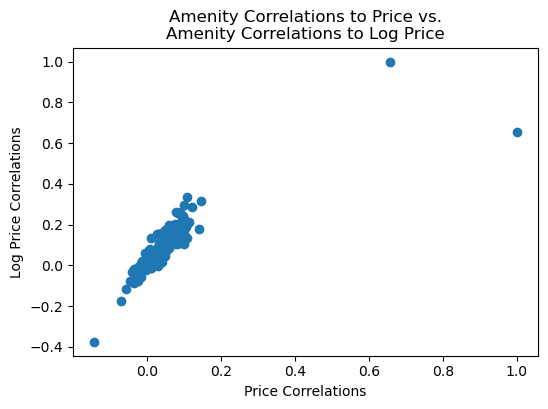

In [19]:
# Check to see if any correlation values are drastically different against price versus log price
plot_vs(price_amen_corr, log_price_amen_corr, 
        title = 'Amenity Correlations to Price vs.\nAmenity Correlations to Log Price',
       x_lbl='Price Correlations', y_lbl='Log Price Correlations')

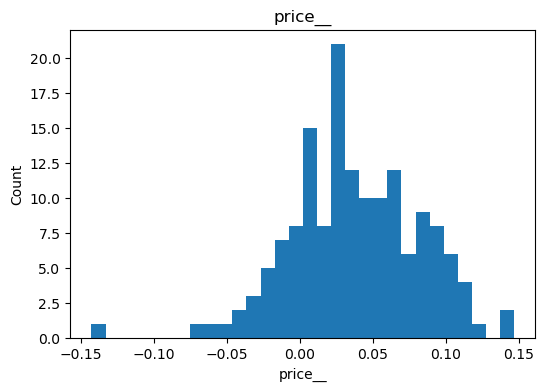

In [20]:
# View the distribution of the correlations (filter out price and log correlations)
hist_plotter(price_amen_corr[price_amen_corr < 0.6], bins = 30)

## 3.4 - Create a Column that Provides the Number of Amenities Provided in Each Listing

In [21]:
# Using regex as before, find the number of amenities for every listing and store to a new column
lstn['amen_cnt'] = lstn.amenities.apply(lambda x: len(re.findall(regex_string, x)))
lstn.amen_cnt

0       20
1       10
2       18
3       29
4       46
        ..
3472    24
3473    29
3474    27
3475     3
3476    53
Name: amen_cnt, Length: 3477, dtype: int64

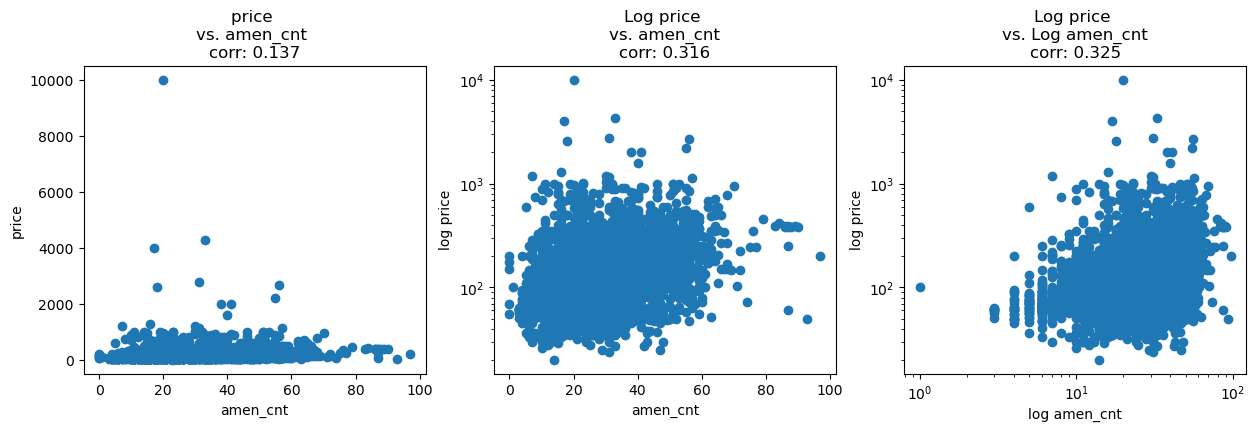

In [22]:
# Plot the price versus amenity count
plot_vs_log(lstn.amen_cnt, lstn.price)

## 3.5 - Amenities Conclusions
* Some amenities correlate higher with price than others
* The amenity counts do not correlate much higher than even the most highly correlated amenities
* Correlations to the log transformed price are much stronger than those to price, but still relatively weak

# 4 - Descriptive Columns

In [23]:
# Check the data type and first value of each of the columns
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(f'{col} type: {type(lstn[col][0])}\n{col} sample value: {lstn[col][0]}\n {"="*50}')

name type: <class 'str'>
name sample value: Private, Quiet, Comfy, Clean Apartment in Boston
description type: <class 'str'>
description sample value: This is the 2 bedroom. It’s one bathroom, giant  closet, TV with cable, and balcony.<br /><br />– Plenty of Pots/Pans/Platters for large meals.<br />– Serving utensils.<br />– Grilling tongs.<br />– Full set of Henkel chef knives.<br />– 2 ovens, 1 grill, 1 dishwasher.<br />– Almost any condiment you need! We keep the fridge and pantry stocked with olive oil, butter, salt, pepper, hot sauce, BBQ sauce, mustard, ketchup, mayo, spices etc.<br /><br />“This room is perfect for responsible guests on a budget who are traveling by themselves!”
host_about type: <class 'float'>
host_about sample value: nan
neighborhood_overview type: <class 'float'>
neighborhood_overview sample value: nan


In [24]:
# Choose another index which does not have null values
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(f'{col} type: {type(lstn[col][10])}\n{col} sample value: {lstn[col][10]}\n {"="*50}')

name type: <class 'str'>
name sample value: Sunny Fenway/Longwood Studio
description type: <class 'str'>
description sample value: Our spacious studio is located just steps from many popular restaurants, world-renowned hospitals, tourist attractions & universities. *PLEASE NOTE- this is on the third floor.<br /><br />We're a 2 minute walk to Fenwood Green Line Subway, 1 mile to Fenway Park, & 0.4 miles to Longwood Medical<br /><br />We are less than a mile from Museum of Fine Arts & the Isabella Stewart Gardner Museum. <br /><br />Some of the cities best attractions are located 1-2 miles from us; Prudential, Boston Common, Newbury St, Chinatown & more!<br /><br /><b>The space</b><br />Our cozy studio is the perfect place for couples, students, nurses, doctors or friends! *PLEASE NOTE, we are located on the third floor*<br />We have a comfy full size bed. There is an HD flat screen TV with You Tube TV, Netflix, HULU, Disney Plus, Paramount and more!<br />Our kitchen is fully equipped wi

In [25]:
# Get counts of null values
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(col, ': ',lstn[col].isnull().sum())

name :  0
description :  13
host_about :  1014
neighborhood_overview :  1232


In [26]:
# Null values can be easily imputed with 'no_text_entered'
#  This can be done as a formal imputation step.
#  The following source confirms taht underscores will not be removed by count vectorizer:
    # https://stackoverflow.com/questions/67856904/countvectorizer-token-pattern-to-not-catch-underscore
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    lstn[col].fillna('no_text_entered', inplace=True)

In [27]:
'''
Write a for loop that will:
* Take all text columns and Count Vectorize their words and ngrams
* Get the correlation coefficients for all words/ngrams with respect to price and log_price
* Create a list stored as a global variable of words/ngrams whose correlation coefficient 
    is above the specified value
''' 

for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    
    # Create a temporary variable to establish the pandas series based on the list
    column_data = lstn[col]
    
    # Instantiate count vectorizer
    cvec_function = CountVectorizer(ngram_range=(1, 4), min_df=0.01)

    # Create a new dataframe with the count vectorized data from the selected column
    cvec_df = pd.DataFrame(cvec_function.fit_transform(column_data).todense(), 
                 columns = cvec_function.get_feature_names_out())
    
    # Add the price and log price columns for easy correlations
    cvec_df['price__'] = lstn.price
    cvec_df['log_price__'] = col_logger(lstn.price)
    print(cvec_df.shape)

    # Create the correlation datafarme:
    corr_df = cvec_df.corr()

    # First ensure there are no NaN values
    print(f"Number of NaN values (price): {corr_df['price__'].isnull().sum()}")
    print(f"Number of NaN values (log price): {corr_df['log_price__'].isnull().sum()}")

    # Find the correlation corefficients for each of the selected column to the price:
    #  Need to filter out correlations to price and log_price with help from the following sources:
        # https://stackoverflow.com/questions/28256761/select-pandas-rows-by-excluding-index-number
        # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    price_corr = corr_df['price__'][~corr_df['price__'].index.isin(['price__', 'log_price__'])]
    log_price_corr = corr_df['log_price__'][~corr_df['log_price__'].index.isin(['price__', 'log_price__'])]

    # Print the values to see them
    print(f'\n{price_corr.sort_values(ascending=False)}')
    print('='*50)
    print(f'\n{log_price_corr.sort_values(ascending=False)}')
    print('='*50)
    print('='*50)

    # Greate list of features (ngrams/words) with relatively high correlation coefficients
    globals()[f'high_cor_feats_{col}'] = list(log_price_corr[abs(log_price_corr) >= .1].index)
#===============================================================================================

(3477, 175)
Number of NaN values (price): 0
Number of NaN values (log price): 0

2ba              0.094392
luxury           0.084990
2br              0.081538
back bay         0.053830
back             0.052917
                   ...   
queen bedroom   -0.089432
private         -0.091811
bedroom         -0.093191
bedroom in      -0.105399
room            -0.139561
Name: price__, Length: 173, dtype: float64

2br              0.167992
luxury           0.150913
back bay         0.144472
back             0.143107
bay              0.133566
                   ...   
queen bedroom   -0.198011
private room    -0.200898
private         -0.203932
bedroom in      -0.236206
room            -0.337365
Name: log_price__, Length: 173, dtype: float64
(3477, 5331)
Number of NaN values (price): 0
Number of NaN values (log price): 0

destination           0.210106
inviting              0.169027
groups                0.154729
spaces                0.141426
together              0.134857
                   

In [28]:
price_corr[abs(price_corr) >= .1]

crossing the    0.114223
guests          0.122042
locals          0.107585
the building    0.105484
why             0.113260
Name: price__, dtype: float64

In [29]:
# See how many sub-features were captured for each lstn feature:

print(len(high_cor_feats_name))
print(len(high_cor_feats_description))
print(len(high_cor_feats_host_about))
print(len(high_cor_feats_neighborhood_overview))

39
811
1335
378


#### OBSERVATIONS:
* Many words in each dataset appear to have correlation coefficients against the log_price data which are above the specified threshold
* Examining the words/ngrams created would be too time consuming and off little value.  Thus, the correlation coefficents are heavily relied upon to identify useful correlations

# 5 - Examine and Encode Host Location and Neighborhood

In [30]:
host_nbd = lstn.host_neighbourhood.value_counts()
print(lstn.host_neighbourhood.isnull().sum())
host_nbd

113


Allston-Brighton                    426
Cambridge                           397
Dorchester                          261
Roxbury                             206
Jamaica Plain                       202
                                   ... 
Wellington Hill                       1
Central Austin                        1
Miravalle                             1
South Lake Tahoe                      1
Metropolitan Hill / Beech Street      1
Name: host_neighbourhood, Length: 104, dtype: int64

In [31]:
host_local = lstn.host_location.value_counts()
print(lstn.host_location.isnull().sum())
host_local

794


Boston, MA                      1899
New York, NY                     409
Massachusetts, United States     101
Hawthorne, NJ                     36
Cambridge, MA                     26
                                ... 
Camden, NJ                         1
Old Lyme, CT                       1
Everett, WA                        1
Richmond, United Kingdom           1
Miami Beach, FL                    1
Name: host_location, Length: 113, dtype: int64

In [32]:
# Print the null counts for each of the above features
print(f'Neighborhood null count: {lstn.host_neighbourhood.isnull().sum()}\nLocation null count: {lstn.host_location.isnull().sum()}')

Neighborhood null count: 113
Location null count: 794


In [33]:
# Create pandas series of the value counts for each

In [34]:
host_local[host_local.index.str.contains('MA')]

Boston, MA                   1899
Cambridge, MA                  26
Brookline, MA                  13
Newburyport, MA                 9
Wayland, MA                     9
Wellesley, MA                   6
Quincy, MA                      5
Milton, MA                      4
Norwood, MA                     3
Newton, MA                      3
Braintree, MA                   3
Malden, MA                      3
Acton, MA                       2
Lexington, MA                   2
Shrewsbury, MA                  2
Dedham, MA                      2
Nantucket, MA                   2
Somerville, MA                  2
Andover, MA                     1
Watertown, MA                   1
Lancaster, MA                   1
Stoughton, MA                   1
Lynnfield, MA                   1
Melrose, MA                     1
Mid-Cambridge, MA               1
Stoneham, MA                    1
Walpole, MA                     1
Wrentham, MA                    1
Beverly, MA                     1
Marblehead, MA

In [35]:
host_local[host_local.index.str.contains('Ma')]

Massachusetts, United States    101
Malden, MA                        3
Macau                             1
Marblehead, MA                    1
Manchester-by-the-Sea, MA         1
Name: host_location, dtype: int64

In [36]:
host_local[host_local.index.str.contains('ma')]

Jamaica                 3
Nassau, Bahamas         1
Alkmaar, Netherlands    1
Name: host_location, dtype: int64

In [37]:
host_local[host_local.index.str.contains('NY')]

New York, NY         409
Latham, NY             1
Central Islip, NY      1
Name: host_location, dtype: int64

In [38]:
# From the above filters, create a list of locations which are not mass or new york city
not_ma_ny_list = list(host_local[(~host_local.index.str.contains('MA')) & (~host_local.index.str.contains('Ma')) & (~host_local.index.str.contains('New York, NY'))].index)

In [39]:
# Need to append 'Macau' from the searches above
not_ma_ny_list.append('Macau')

In [40]:
# Create a list of places which are not Boston
outside_bos = list(host_local[(host_local.index.str.contains('MA')) & (~host_local.index.str.contains('Boston'))].index)

In [41]:
# Need to add the general Massachusetts location to the outside_bos_cam list
outside_bos.append('Massachusetts, United States')

In [42]:
# Fill null values prior to re-mapping locations
lstn.host_location.fillna('not_listed', inplace=True)

In [43]:
def location_classifier(x):
    if x in outside_bos:
        return 'outside_bos'
    elif x in not_ma_ny_list:
        return 'some_other_place'
    else:
        return x

In [44]:
# Check value counts to ensure proper encoding 
lstn.host_location.apply(lambda x: location_classifier(x)).value_counts()

Boston, MA          1899
not_listed           794
New York, NY         409
outside_bos          221
some_other_place     154
Name: host_location, dtype: int64

In [45]:
# Establish the enocded values in the dataframe
lstn.host_location = lstn.host_location.apply(lambda x: location_classifier(x))

In [46]:
# Fill null values prior to re-mapping locations
lstn.host_neighbourhood.fillna('not_listed', inplace=True)

In [61]:
# See the neighborhoods that are listed for non-Boston locations
lstn[lstn.host_location == 'Boston, MA']['host_neighbourhood'].value_counts()

Dorchester              216
Jamaica Plain           173
Roxbury                 147
Allston-Brighton        143
South End               100
                       ... 
Franklin Field North      1
East Downtown             1
Harwich Port              1
South Beach               1
Financial District        1
Name: host_neighbourhood, Length: 67, dtype: int64

In [62]:
'''
Above, some Boston neighborhoods have been encoded in non-Boston locations, probably as general
Massachusetts locations.  The locations should be fixed by using the boston locations to get a
list of Boston neighborhoods and then imputing Boston into the fields that need to be corrected.
'''

# Create a list of Boston neighborhoods
bos_nbr_list = list(lstn[lstn.host_location == 'Boston, MA']['host_neighbourhood'].value_counts().index)

---
---

You may need to cite the following soureces:
* https://stackoverflow.com/questions/33769860/pandas-apply-but-only-for-rows-where-a-condition-is-met
* https://www.geeksforgeeks.org/apply-a-function-to-single-or-selected-columns-or-rows-in-pandas-dataframe/
* https://builtin.com/data-science/pandas-filter
* https://www.statology.org/pandas-series-filter-by-value/


In [98]:
sweetness = lstn.host_neighbourhood.copy()

np.where(sweetness == 'South End', 'sweet')

ValueError: either both or neither of x and y should be given

In [103]:
sweetness[[0, 1]] = 'boop'

In [104]:
sweetness

0                   boop
1                   boop
2          Jamaica Plain
3              South End
4              Cambridge
              ...       
3472         Beacon Hill
3473    Allston-Brighton
3474           Hyde Park
3475    Allston-Brighton
3476        South Boston
Name: host_neighbourhood, Length: 3477, dtype: object

In [63]:
lstn[(lstn.host_location != 'Boston, MA') & ][['host_neighbourhood', 'host_location']]

,host_neighbourhood,host_location
1,Roxbury,"Boston, MA"
2,Jamaica Plain,"Boston, MA"
3,South End,"Boston, MA"
6,Jamaica Plain,"Boston, MA"
7,Jamaica Plain,"Boston, MA"
...,...,...
3470,Allston-Brighton,"Boston, MA"
3471,Dorchester,"Boston, MA"
3472,Beacon Hill,"Boston, MA"
3473,Allston-Brighton,"Boston, MA"


---
---

# APPENDIX OR JUNK

In [117]:
'Pack \\u2019n p'

'Pack \\u2019n p'

In [120]:
amn_counts[amn_counts >= 100].index[-1]

'Pack \\u2019n play/Travel crib - available upon request'

In [127]:
len([i for i in lstn.amenities if '\\u2019n' in i])

382

In [140]:
df = lstn['amenities']

In [141]:
df

0       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
1       ["Wifi", "Carbon monoxide alarm", "Hot water",...
2       ["Shampoo", "Carbon monoxide alarm", "Wifi", "...
3       ["Wifi", "Kitchen", "First aid kit", "Refriger...
4       ["Wifi", "Window guards", "Kitchen", "Long ter...
                              ...                        
3472    ["Wifi", "Stove", "Kitchen", "Dishwasher", "Re...
3473    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3474    ["Wifi", "Stove", "Keypad", "Kitchen", "Dishwa...
3475                        ["Wifi", "Microwave", "Oven"]
3476    ["Clothing storage: wardrobe and closet", "Cit...
Name: amenities, Length: 3477, dtype: object

In [ ]:
#regex_string = '(?<=")[^"]+(?=",)'
regex_string_new = '(?<=")[^"]+(?="[,\]])'

In [254]:
# Find the correlation coefficient between the number of amenities listed and the price
np.corrcoef(lstn.amen_cnt, lstn.price)[0][1]

0.13731144502525244

In [275]:
# Test to see if there is a stronger correlation with the log of the price
#  A lambda funciton is used to hand the 0 values (which cannot be log transformed)
np.corrcoef(lstn.amen_cnt, col_logger(lstn.price))[0][1]

0.3156277419865199

In [276]:
# Check the correlation of both variables log transformed
np.corrcoef(col_logger(lstn.amen_cnt), col_logger(lstn.price))[0][1]

0.3246712981483639

In [83]:

# import pandas and numpy library
import pandas as pd
import numpy as np
# List of Tuples
matrix = [(1, 2, 3),
          (4, 5, 6),
          (7, 8, 9)
         ]
 
# Create a DataFrame object
df = pd.DataFrame(matrix, columns = list('xyz'),
                   index = list('abc'))
 
# Apply function numpy.square() to lambda
# whose row index is 'b'
new_df = df.apply(lambda x: np.square(x) if x.name == 'b' else x,
                axis = 1)

In [86]:
df

,x,y,z
a,1,2,3
b,4,5,6
c,7,8,9


In [87]:
new_df

,x,y,z
a,1,2,3
b,16,25,36
c,7,8,9


In [94]:
df['y'].iloc[0].name

AttributeError: 'numpy.int64' object has no attribute 'name'